<a href="https://colab.research.google.com/github/ZachNK/CoLab_M_Net_1/blob/master/M_Net_project_KNK_1_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation

모델: M-Net


---

![Model](https://drive.google.com/uc?id=1B6Vot8QlIaQ3osrlB8Wj9frUkC_IcWaW)


---


참고문헌: 
Mehta, R., & Sivaswamy, J. (2017, April). M-net: A convolutional neural network for deep brain structure segmentation. In 2017 IEEE 14th International Symposium on Biomedical Imaging (ISBI 2017) (pp. 437-440). IEEE. 

http://doi.org/10.1109/ISBI.2017.7950555

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Imports와 데이터 셋

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [0]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

# image_generator

In [0]:
def image_generator(files, batch_size = 8, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256, 1) --> (20, 256, 256, 2)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 8 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [0]:
print (x.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256, 2)


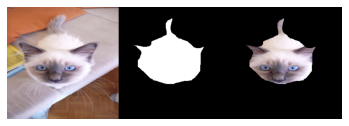

In [0]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)

msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256, 2) -> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

#Loss Function

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. -score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def block_residual(x, nKernels):
  identity = x
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity


# Model

In [0]:
from tensorflow.keras.layers import concatenate
def mnet(sz=(256, 256, 3)):
    nKernel = 16
    inputs=Input((256, 256, 3)) #(256, 256, 3)
    input_feature=Conv2D(16, 1, activation='relu') (inputs)
    #print("input_feature: ",input_feature.shape) # //

    #Left Leg
    L_Leg_1 = MaxPooling2D((2,2))(input_feature) #(128, 128, 16)
    #print("L_Leg_1: ",L_Leg_1.shape) # //
    L_Leg_2 = MaxPooling2D((2,2)) (L_Leg_1) #(64, 64, 16)
    #print("L_Leg_2: ",L_Leg_2.shape) # //
    L_Leg_3 = MaxPooling2D((2,2)) (L_Leg_2) # (32, 32, 16)
    #print("L_Leg_3: ",L_Leg_3.shape) # //

    #Layer 1, size= (256, 256, 16)--> (256, 256, 32)
    layer1_1=Conv2D(nKernel*1, 3, activation='relu', padding='same') (input_feature) # (256, 256, 16)
    layer1_1=BatchNormalization()(layer1_1) # (256, 256, 16)


    layer1_c=concatenate([layer1_1, input_feature]) # (256, 256, 32)
    #print("layer1_2: ",layer1_c.shape) #//
    layer1_2=Conv2D(nKernel*2, 3, activation='relu', padding='same')(layer1_c) # (256, 256, 32)
    layer1_2=BatchNormalization()(layer1_2) # (256, 256, 32) #Layer 1 FM 
    layer1_p=MaxPooling2D((2,2))(layer1_2) # (128, 128, 32)


    #Layer 2, size= (128, 128, 32)--> (128, 128, 48)
    layer2_1=concatenate([layer1_p, L_Leg_1]) # (128, 128, 32+16=48)
    layer2_2=Conv2D(nKernel*2, 3, activation='relu', padding='same') (layer2_1) # (128, 128, 32)
    layer2_2=BatchNormalization()(layer2_2) # (128, 128, 32)

    layer2_c=concatenate([layer1_p, layer2_2]) # (128, 128, 32+32=64)
    layer2_3=Conv2D(nKernel*3, 3, activation='relu', padding='same')(layer2_c) # (128, 128, 48)
    layer2_3=BatchNormalization()(layer2_3) # (128, 128, 48) #Layer 2 FM
    layer2_p=MaxPooling2D((2,2))(layer2_3) # (64, 64, 48)
    #print("layer2_3: ",layer2_3.shape) # //

    #Layer 3, size= (64, 64, 48) --> (64, 64, 64)
    layer3_1=concatenate([layer2_p, L_Leg_2]) # (64, 64, 48+16=64)
    layer3_2=Conv2D(nKernel*3, 3, activation='relu', padding='same') (layer3_1) # (64,64, 48)
    layer3_2=BatchNormalization()(layer3_2) # (64, 64, 48)

    layer3_c=concatenate([layer2_p, layer3_2]) # (64, 64, 48+48=96)
    layer3_3=Conv2D(nKernel*4, 3, activation='relu', padding='same')(layer3_c) # (64, 64, 64)
    layer3_3=BatchNormalization()(layer3_3) # (64, 64, 64) #Layer 3 FM
    layer3_p=MaxPooling2D((2,2))(layer3_3) # (32, 32, 64)
    #print("layer3_3: ",layer3_3.shape) #//
    #print("layer3_p: ", layer3_p.shape) #//

    #Layer 4, size= (32, 32, 64)--> (32, 32, 128) 
    layer4_1=concatenate([layer3_p, L_Leg_3]) # (32, 32, 64+16=80)
    layer4_2=Conv2D(nKernel*4, 3, activation='relu', padding='same') (layer4_1) # (32, 32, 64)
    layer4_2=BatchNormalization()(layer4_2) # (32, 32, 64)

    # Bottle-Neck
    layer4_c=concatenate([layer3_p, layer4_2]) # (32, 32, 64+64=128)
    layer4_3=Conv2D(nKernel*8, 3, activation='relu', padding='same')(layer4_c) # (32, 32, 128)
    layer4_3=BatchNormalization()(layer4_3) # (32, 32, 128)

    # size = (32, 32, 128)--> (32, 32, 64)
    layer4_4=Conv2D(nKernel*4, 3, activation='relu', padding='same')(layer4_3) # (32, 32, 64)
    layer4_4=BatchNormalization()(layer4_4) # (32, 32, 64) #Layer 4 FM
    layer4_u=UpSampling2D((2,2))(layer4_4) # (64, 64, 64)
    #print("layer4_4: ",layer4_4.shape) # --> (32, 32, 64) //
    #print("layer4_u: ",layer4_u.shape) # --> (128, 128, 64) //

    #Layer 5, size = (64, 64, 64) --> (64, 64, 48) # Concate /w Layer 3 FM
    layer5_1=concatenate([layer4_u, layer3_3]) # (64, 64, 64+64=128)
    layer5_2=Conv2D(nKernel*4, 3, activation='relu', padding='same') (layer5_1) # (64, 64, 64)
    layer5_2=BatchNormalization()(layer5_2) # (64, 64, 64)
    #print("layer5_2: ", layer5_2.shape)

    layer5_c=concatenate([layer5_2, layer4_u]) # (64, 64, 64+64=128)
    layer5_3=Conv2D(nKernel*3, 3, activation='relu', padding='same')(layer5_c) # (64, 64, 48)
    layer5_3=BatchNormalization() (layer5_3) # (64, 64, 48) #Layer 5 FM
    layer5_u=UpSampling2D((2,2))(layer5_3) # (128, 128, 48)
    #print("layer5_3: ",layer5_3.shape)

    #Layer 6, size = (128, 128, 48) --> (128, 128, 32) # Concate /w Layer 2 FM
    layer6_1=concatenate([layer5_u, layer2_3]) # (128, 128, 48+48=96)
    layer6_2=Conv2D(nKernel*3, 3, activation='relu', padding='same') (layer6_1) # (128, 128, 48)
    layer6_2=BatchNormalization()(layer6_2) # (128, 128, 48)

    layer6_c=concatenate([layer6_2, layer5_u]) # (128, 128, 48+48=96)
    layer6_3=Conv2D(nKernel*2, 3, activation='relu', padding='same')(layer6_c) # (128, 128, 32)
    layer6_3=BatchNormalization() (layer6_3) # (128, 128, 32) #Layer 6 FM
    layer6_u=UpSampling2D((2,2))(layer6_3) # (256, 256, 32)
    #print("layer6_3: ",layer6_3.shape)

    #Layer 7, size = (256, 256, 32) --> (256, 256, 16) # Concate /w Layer 1 FM
    layer7_1=concatenate([layer6_u,layer1_2]) # (256, 256, 32+32=64)
    layer7_2=Conv2D(nKernel*2, 3, activation='relu', padding='same') (layer7_1) # (256, 256, 32)
    layer7_2=BatchNormalization() (layer7_2) # (256, 256, 32)

    layer7_c=concatenate([layer7_2, layer6_u]) # (256, 256, 32+32=64)
    layer7_3=Conv2D(nKernel*1, 3, activation='relu', padding='same') (layer7_c) # (256, 256, 16) 
    layer7_3=BatchNormalization() (layer7_3) # (256, 256, 16) # Layer 7 FM
    #print("layer7_3: ",layer7_3.shape)

    R_leg_1 = UpSampling2D((8, 8)) (layer4_4) # (32, 32, 64) --> (256, 256, 64)
    R_leg_2 = UpSampling2D((4, 4)) (layer5_3) # (64, 64, 48) --> (256, 256, 48)
    R_leg_3 = UpSampling2D((2, 2)) (layer6_3) # (128, 128, 32) --> (256, 256, 16)

    final_layer = concatenate([layer7_3, R_leg_3, R_leg_2, R_leg_1])



    # Output
    outputs = Conv2D(2, 1, activation='softmax') (final_layer)

    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])
    
    return model


In [0]:
model = mnet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

877 46


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
i= 1 loss= 0.7888664310647253 val_loss= 0.5326694995164871 mean_dsc= 0.63684374 val_mean_dsc= 0.77670294


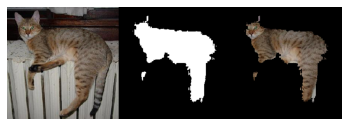

i= 2 loss= 0.49618888672700356 val_loss= 0.640263552898946 mean_dsc= 0.7884418 val_mean_dsc= 0.75731134


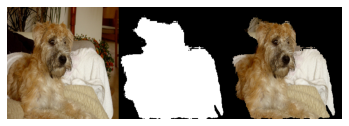

i= 3 loss= 0.4230123530635812 val_loss= 0.3794211609208066 mean_dsc= 0.82344925 val_mean_dsc= 0.8390907


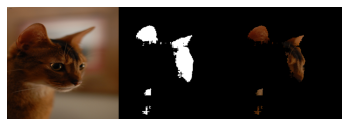

i= 4 loss= 0.38186472457246334 val_loss= 0.4847585072983866 mean_dsc= 0.84046566 val_mean_dsc= 0.7890318


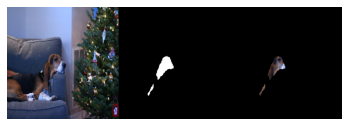

i= 5 loss= 0.3496739948964853 val_loss= 0.38980336357717926 mean_dsc= 0.8546451 val_mean_dsc= 0.84698486


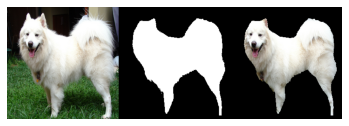

i= 6 loss= 0.3349090818498398 val_loss= 0.3739830576207327 mean_dsc= 0.8616724 val_mean_dsc= 0.8376633


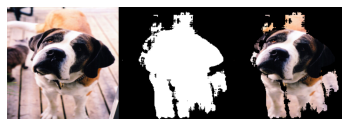

i= 7 loss= 0.3150197316296696 val_loss= 0.2954459433322367 mean_dsc= 0.86958367 val_mean_dsc= 0.8786341


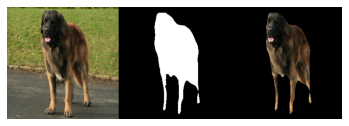

i= 8 loss= 0.2941176358996938 val_loss= 0.3744008288435314 mean_dsc= 0.8788668 val_mean_dsc= 0.84435236


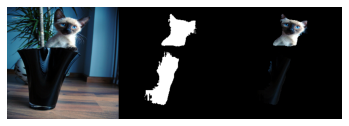

i= 9 loss= 0.2851273278995686 val_loss= 0.29158468836027646 mean_dsc= 0.8829829 val_mean_dsc= 0.88188976


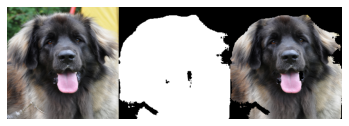

i= 10 loss= 0.27890225566983085 val_loss= 0.3337724309252656 mean_dsc= 0.8866299 val_mean_dsc= 0.86335325


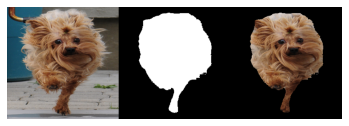

In [0]:
model.fit_generator(train_generator, 
                    epochs = 10, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-12 20:27:50--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.12.16, 13.224.12.41, 13.224.12.79, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.12.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-05-12 20:27:50 (5.44 MB/s) - ‘test.jpg’ saved [63219/63219]



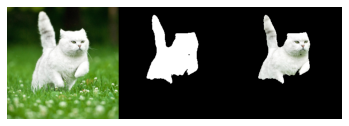

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()